In [7]:
from emlp.nn import MLP,EMLP,MLPH,EMLPH
from emlp.groups import SO2eR3,O2eR3,DkeR3,Trivial
from emlp.reps import Scalar
# from trainer.hamiltonian_dynamics import IntegratedDynamicsTrainer,DoubleSpringPendulum,hnn_trial
import sys
sys.path.append("../")
from trainer.hamiltonian_dynamics import WindyDoubleSpringPendulum, BHamiltonianFlow
from torch.utils.data import DataLoader
from oil.utils.utils import cosLr,FixedNumpySeed,FixedPytorchSeed
from trainer.utils import LoaderTo
from oil.datasetup.datasets import split_dataset
from oil.tuning.args import argupdated_config

sys.path.append("../../")
from RPP.rpp_objax import MixedEMLP, MixedEMLPH
from datasets import ModifiedInertia
import torch.nn as nn
import numpy as np
import pandas as pd
import jax.numpy as jnp
import objax
import os

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
dataset = WindyDoubleSpringPendulum
base_ds = dataset(wind_scale=0.01, n_systems=5000,chunk_len=5)

In [10]:
net_config={'num_layers':3,'ch':128,'group':base_ds.symmetry}
model = MixedEMLPH(base_ds.rep_in, Scalar, **net_config)

In [11]:
def compute_l2(model):
    basic_l2 = sum((v.value ** 2).sum() for k, v in model.vars().items() if k.endswith('w_basic'))
    equiv_l2 = sum((v.value ** 2).sum() for k, v in model.vars().items() if k.endswith('w_equiv'))
    return basic_l2.item(), equiv_l2.item()

In [12]:
trials = np.arange(7)
wind_levels = np.arange(0.0, 0.041, 0.002)

logger = []
for trial in trials:
    for wnd in wind_levels:
        wnd = np.round(wnd, 3)
        fname = "./saved-outputs/mdl_wind_scale" + str(wnd) +\
                "_trial" + str(trial) + ".npz"
        if os.path.exists(fname):
            objax.io.load_var_collection(fname, model.vars())
            basic_l2, equiv_l2 = compute_l2(model)

            logger.append([trial, wnd, basic_l2, equiv_l2])

In [13]:
df = pd.DataFrame(logger)
df.columns = ['trial', 'wind', 'basic_l2', 'equiv_l2']

In [14]:
fs = 14

Text(0.5, 0, 'Wind Scale')

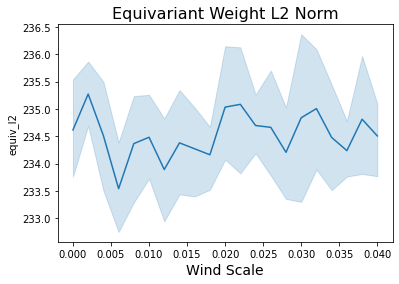

In [15]:

sns.lineplot(x='wind', y='equiv_l2', data=df)
plt.title("Equivariant Weight L2 Norm", fontsize=fs+2)
plt.xlabel("Wind Scale", fontsize=fs)

Text(0.5, 0, 'Wind Scale')

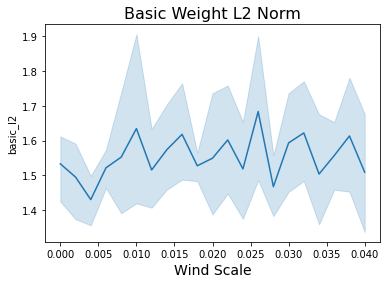

In [16]:
sns.lineplot(x='wind', y='basic_l2', data=df)
plt.title("Basic Weight L2 Norm", fontsize=fs+2)
plt.xlabel("Wind Scale", fontsize=fs)